**Import the Libraries**

In [1]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
print(tf.__version__)

2.3.0


In [2]:
import time

start = time.time()



**Get the Data**

!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

**Import NTLK Library**

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\G7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Set the Hyper-Parameters**

In [4]:
vocab_size = 5000 
embedding_dim = 70 # 64
max_length = 100 # 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' #OOV = Out of Vocabulary
training_portion = .9

frac_dropout = 0.8 # 0.5

learn_rate = 0.001 # 0.001
decay_rate = 1e-6 # 1e-6

n_epoch = 14

n_out = 7 # number of elements in 'softmax'

**Populate List and Remove the Stopwords**

improvement,"Dear Campboss 

Kindly explain how to manage and prepare Thai food for night shift personnel recently on last night observed that some Thai food menu had finished early before night shift personnel especially Thai tech. went for midnight meal but found a lot of day shift and night shift personnel(Catering and RT team) enjoy having Thai food meal while we just only look, Thai cook told us he prepared full tray of Tomyam but it was magically gone. on our understanding that Thai food is for everyone but priority is for Thai Tech.

Best regards,
Production night shift"

In [5]:
articles = []
labels = []

with open("train_2019.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

8863
8863


In [6]:
labels

['observation',
 'condition',
 'observation',
 'observation',
 'condition',
 'condition',
 'observation',
 'condition',
 'condition',
 'observation',
 'condition',
 'observation',
 'condition',
 'condition',
 'maintenance',
 'act',
 'act',
 'condition',
 'condition',
 'observation',
 'condition',
 'act',
 'improvement',
 'improvement',
 'observation',
 'observation',
 'maintenance',
 'condition',
 'condition',
 'condition',
 'observation',
 'condition',
 'observation',
 'improvement',
 'condition',
 'observation',
 'observation',
 'condition',
 'condition',
 'observation',
 'act',
 'observation',
 'observation',
 'observation',
 'observation',
 'improvement',
 'observation',
 'observation',
 'observation',
 'observation',
 'act',
 'observation',
 'observation',
 'improvement',
 'observation',
 'observation',
 'observation',
 'maintenance',
 'condition',
 'condition',
 'improvement',
 'condition',
 'observation',
 'observation',
 'condition',
 'condition',
 'act',
 'observation',
 'act'

In [7]:
articles[1]

'found knife main deck chair security patrol. keep right place remind crew housekeeping done job '

**Create Training and Validation Set**

In [8]:
# -- deprecated
#
#train_size = int(len(articles) * training_portion)
#
#train_articles = articles[0: train_size]
#train_labels = labels[0: train_size]
#
#validation_articles = articles[train_size:]
#validation_labels = labels[train_size:]

train_articles, validation_articles, train_labels, validation_labels = train_test_split(articles, labels, test_size=1-training_portion, random_state=42)

#print("train_size",  train_size)
print("train_articles", len(train_articles))
print("train_labels", len(train_labels))
print("validation_articles", len(validation_articles))
print("validation_labels", len(validation_labels))

train_articles 7976
train_labels 7976
validation_articles 887
validation_labels 887


**Tokenization on "train_articles"**

In [9]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

word_index

{'<OOV>': 1,
 'observed': 2,
 'found': 3,
 'deck': 4,
 'crew': 5,
 'work': 6,
 'good': 7,
 'area': 8,
 'observe': 9,
 'scaffolding': 10,
 'left': 11,
 'activity': 12,
 'safety': 13,
 'water': 14,
 'grating': 15,
 'wearing': 16,
 'fire': 17,
 'air': 18,
 'properly': 19,
 'inside': 20,
 'check': 21,
 'working': 22,
 'floor': 23,
 'hose': 24,
 'using': 25,
 'room': 26,
 'start': 27,
 'housekeeping': 28,
 'one': 29,
 'scaffolder': 30,
 'hazard': 31,
 'painting': 32,
 'personnel': 33,
 'use': 34,
 'team': 35,
 'proper': 36,
 'main': 37,
 'condition': 38,
 'transfer': 39,
 'wear': 40,
 'used': 41,
 'potential': 42,
 'job': 43,
 'storage': 44,
 'engine': 45,
 'during': 46,
 'without': 47,
 'cause': 48,
 'hot': 49,
 'communication': 50,
 'lifting': 51,
 'ppe': 52,
 'hand': 53,
 'door': 54,
 'full': 55,
 'secure': 56,
 'empty': 57,
 'pipe': 58,
 'still': 59,
 'waste': 60,
 'paint': 61,
 'due': 62,
 'boat': 63,
 'cable': 64,
 'perform': 65,
 'vest': 66,
 'near': 67,
 'platform': 68,
 'equipment'

**Convert to Sequences on "train_articles"**

In [10]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [11]:
print(train_sequences[10]), len(train_sequences[10])

[7, 104, 311, 22, 25, 283, 150, 51, 73]


(None, 9)

In [12]:
print(train_sequences[0]), len(train_sequences[0])

[2, 25, 283, 150, 65, 242, 6, 12, 124]


(None, 9)

**Padding and Truncating on "train_sequences"**

In [13]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
train_padded[1]

array([  9,  10,  44, 154, 208,   7, 202,  38,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [15]:
print("len train_sequnces[0]: ", len(train_sequences[0]))
print("len train_padded[0]: ", len(train_padded[0]))

print("len train_sequences[1]: ", len(train_sequences[1]))
print("len train_padded[1]: ", len(train_padded[1]))

print("len train_sequences[10]: ", len(train_sequences[10]))
print("len train_padded[10]: ", len(train_padded[10]))

len train_sequnces[0]:  9
len train_padded[0]:  100
len train_sequences[1]:  8
len train_padded[1]:  100
len train_sequences[10]:  9
len train_padded[10]:  100


**Convert to Sequence, Padding & Truncating on "validation_articles"**

In [16]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

887
(887, 100)


**Labels**

In [17]:
label = np.unique(labels)

In [18]:
print(set(labels))
print(len(set(labels)))

{'observation', 'containment', 'condition', 'improvement', 'maintenance', 'act'}
6


**Tokenize and Convert to Sequence on "train_labels" and "validation_labels"**

In [19]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [20]:
#labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
label_tokenizer.word_index

{'condition': 1,
 'observation': 2,
 'act': 3,
 'maintenance': 4,
 'improvement': 5,
 'containment': 6}

In [21]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[2]
[2]
[2]
(7976, 1)
-------------
[4]
[1]
[1]
(887, 1)


**Create Model**

In [22]:
model = Sequential()

# added the following
#model.add(Embedding(vocab_size, embedding_dim))
#model.add(Dropout(frac_dropout))

# original
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(frac_dropout))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dropout(frac_dropout))
model.add(Dense(n_out, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 70)          350000    
_________________________________________________________________
dropout (Dropout)            (None, None, 70)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 140)               78960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 987       
Total params: 429,947
Trainable params: 429,947
Non-trainable params: 0
_________________________________________________________________


**Compile the Model**

In [23]:
opt = tf.keras.optimizers.Adam(lr=learn_rate, decay=decay_rate)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

**Train the Model**

In [24]:
num_epochs = n_epoch
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/14
250/250 - 12s - loss: 1.1095 - accuracy: 0.5923 - val_loss: 0.8090 - val_accuracy: 0.7430
Epoch 2/14
250/250 - 11s - loss: 0.7502 - accuracy: 0.7712 - val_loss: 0.7136 - val_accuracy: 0.7610
Epoch 3/14
250/250 - 11s - loss: 0.6510 - accuracy: 0.7975 - val_loss: 0.6376 - val_accuracy: 0.8050
Epoch 4/14
250/250 - 10s - loss: 0.5743 - accuracy: 0.8238 - val_loss: 0.6033 - val_accuracy: 0.8038
Epoch 5/14
250/250 - 11s - loss: 0.5355 - accuracy: 0.8338 - val_loss: 0.5743 - val_accuracy: 0.8241
Epoch 6/14
250/250 - 11s - loss: 0.4924 - accuracy: 0.8529 - val_loss: 0.5524 - val_accuracy: 0.8253
Epoch 7/14
250/250 - 11s - loss: 0.4747 - accuracy: 0.8597 - val_loss: 0.5501 - val_accuracy: 0.8241
Epoch 8/14
250/250 - 11s - loss: 0.4510 - accuracy: 0.8663 - val_loss: 0.5462 - val_accuracy: 0.8230
Epoch 9/14
250/250 - 11s - loss: 0.4289 - accuracy: 0.8737 - val_loss: 0.5613 - val_accuracy: 0.8264
Epoch 10/14
250/250 - 11s - loss: 0.4108 - accuracy: 0.8773 - val_loss: 0.5468 - val_accura

**Plot the Graph**

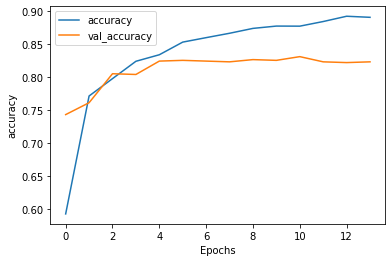

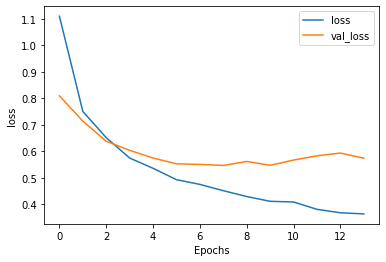

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# **Prediction**

In [26]:
print(label_tokenizer.word_index)

{'condition': 1, 'observation': 2, 'act': 3, 'maintenance': 4, 'improvement': 5, 'containment': 6}


In [27]:
label_arr = list(label_tokenizer.word_index)
print(label_arr)

['condition', 'observation', 'act', 'maintenance', 'improvement', 'containment']


## Read Test data from file

In [28]:
# read data

articles = []
labels = []

with open("test_2020.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

8702
8702


In [29]:
test_articles = articles
test_labels = labels

test_sequences = tokenizer.texts_to_sequences(test_articles)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## predict training set (with multiple input)

In [30]:
train_predicted = model.predict_on_batch(train_padded)

pred_labels = [label_arr[np.argmax(i)-1] for i in train_predicted]

train_accuracy = np.sum(np.array(pred_labels) == np.array(train_labels))/len(train_labels)
print(train_accuracy)

0.9247743229689067


## predict validation set (with multiple input)

In [31]:
val_predicted = model.predict_on_batch(validation_padded)

pred_labels = [label_arr[np.argmax(i)-1] for i in val_predicted]

val_accuracy = np.sum(np.array(pred_labels) == np.array(validation_labels))/len(validation_labels)
print(val_accuracy)

0.8229988726042841


## predict test set (with multiple input)

In [32]:
test_predicted = model.predict_on_batch(test_padded)

pred_labels = [label_arr[np.argmax(i)-1] for i in test_predicted]

print(len(pred_labels))

test_accuracy = np.sum(np.array(pred_labels) == np.array(test_labels))/len(test_labels)
print(test_accuracy)

8702
0.727189151919099


## write to csv

In [35]:
x_out1 = pd.DataFrame(pred_labels)
x_out2 = pd.DataFrame(test_labels)
x_in = pd.DataFrame(test_articles, columns=['reports'])

x_out1.columns = ['predicted']
x_out2.columns = ['actual']

x_out = pd.concat([x_out1, x_out2], axis=1, ignore_index=True)
x_out.columns = ['predicted', 'actual']

x = pd.concat([x_out, x_in], axis=1)
x

x.to_csv('results_nov_2020.csv')

print(x.shape)

(8702, 3)


In [34]:
end = time.time()

elapsed = end - start

print(elapsed)

183.9584984779358
